In [148]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import KFold
import numpy as np
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
import statsmodels.formula.api as sm
from scipy import stats
import tensorflow as tf
from sklearn.model_selection import train_test_split
from statistics import mode

## Read in data
Seperating the attributes from the result

In [77]:
file = pd.read_csv("heart_data.txt")

cols = ['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age']
data = pd.DataFrame([file[col] for col in cols]).T
famhist = [1 if val == 'Present' else 0 for val in file['famhist']]
data['famhist'] = famhist
data = pd.DataFrame(zscore(data, ddof=1))
cols.append('famhist')
data.columns = cols

data

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,famhist
0,1.057417,1.821099,0.477894,-0.295183,-0.418017,-0.176594,3.274189,0.628654,1.184570
1,0.276789,-0.789382,-0.159507,0.411694,0.193134,0.670646,-0.612081,1.381617,-0.842361
2,-0.991731,-0.774141,-0.608585,0.883374,-0.112441,0.734723,-0.540597,0.217947,1.184570
3,1.545310,0.841352,0.806252,1.622382,-0.214300,1.411091,0.294742,1.039361,1.184570
4,-0.211103,2.169453,-0.598928,0.305020,0.702427,-0.012842,1.645991,0.423301,1.184570
...,...,...,...,...,...,...,...,...,...
457,3.692037,-0.704470,0.598614,0.811401,1.109862,0.570971,-0.696228,1.039361,-0.842361
458,2.130781,0.122871,-0.159507,0.860240,-0.112441,0.608942,0.068445,0.628654,-0.842361
459,-1.479624,-0.138395,-1.521228,-1.307946,-1.334744,-1.413043,0.391960,0.834008,-0.842361
460,-0.991731,0.384137,3.317227,0.691875,1.109862,0.309916,0.282897,-0.192760,-0.842361


## NN loop
This is the actual loop running the machine learning model

In [149]:
def ANN_model(
        epochs: int, 
        h: int, 
        x_train: object, 
        x_test: object,
        y_train: object,
        y_test: object, 
        n_out: int = 1, 
        lr: float = 0.1,
        confusion: bool = False
    ):
    """
    Function for running (training and testing) ANN model for each k-fold or subset of k-folds
    """
    
    train_loss, test_loss = np.zeros(shape=(epochs)), np.zeros(shape=(epochs))
    try:
        x_train.size(dim=1)
    except:
        print(type(x_train))
    # Defining the model for each fold
    model = nn.Sequential(nn.Linear(x_train.size(dim=1), h),
                          nn.Linear(h, n_out),
                          nn.Tanh())
    loss_function = nn.L1Loss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # Running model
    for i in range(epochs):
        pred_y = model(x_train) # Get prediction for training data
        loss = loss_function(pred_y.flatten(), y_train) # Get loss, based on prediction
        train_loss[i] = loss

        pred_y_test = model(x_test) # Get prediction for test data
        loss_test = loss_function(pred_y_test.flatten(), y_test) # Get loss based on prediction
        test_loss[i] = loss_test
        
        model.zero_grad()
        loss.backward()

        optimizer.step()
    if confusion:
        pred_y_bin = torch.round(pred_y_test)
        conf_mtx = confusion_matrix(y_test.detach().numpy(), pred_y_bin.detach().numpy())
        return train_loss, test_loss, conf_mtx
    
    return train_loss, test_loss


In [92]:
def linear_regression(X_train, X_test, y_train, y_test, wd):
    #Model
    n_features = len(cols) - 1
    input_size = n_features
    output_size = 1

    model = nn.Linear(input_size, output_size)

    #Loss & Optimizer
    loss_function = nn.MSELoss()
    learning_rate = 0.01

    #wd = 0.001 #Use this if not looping

    step = []
    training_loss = []
    testing_loss = []

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = wd)
    
    #Training
    epochs = 100
    for epoch in range(epochs):
        #Forwards pass + loss
        y_predicted = model(X_train.float())
        loss = loss_function(y_predicted.flatten(), y_train)
        
        #Backwards pass
        loss.backward()
        
        #update
        optimizer.step()
        
        optimizer.zero_grad()
        
#        if (epoch+1) % 100 == 0:
#            print(f'epoch: {epoch+1}, lambda = {wd:.3f}, loss = {loss.item():.4f}')
    
    
    #Testing
    test_predicted = model(X_test.float())
    test_loss = loss_function(test_predicted.flatten(), y_test)
    test_loss = test_loss.detach()

    step.append(wd)
    training_loss.append(loss.item())
    testing_loss.append(test_loss)

    return training_loss, testing_loss


## Logistic regression

In [80]:
def log_reg(
    x_train: object, 
    x_test: object, 
    y_train: object, 
    y_test: object,
    C: float):

    logreg = LogisticRegression(solver='liblinear', C = C) #Defining solver
    logreg.fit(x_train,y_train) #Modelfitting

    # pred_y_log = logreg.predict(x_test) 

    pred_y_log_train = logreg.predict(x_train) # Get prediction for training data
    loss_train = mean_squared_error(pred_y_log_train.flatten(), y_train) # Get loss, based on prediction

    pred_y_log_test = logreg.predict(x_test) # Get prediction for test data
    loss_test = mean_squared_error(pred_y_log_test.flatten(), y_test) # Get loss based on prediction

    return loss_train, loss_test


In [151]:
def kfold_iterations(x_data: object, y_data: object, epochs: int, hidden_neurons: list, C: list, k: int = 10, Classifier: bool = False):
    
    k_inner = len(hidden_neurons) # Make as many k-folds as there are hidden neurons
    
    best_model_NN = np.zeros(shape=k) # The number of hidden neurons for the best models will be stored here
    best_model_LogClass = np.zeros(shape=k) # The number of lambda complexity
        
    
    E_i_NN, final_train_error_NN = np.zeros(shape=k), np.zeros(shape=k) # Error for best model in each k-fold will be stored here
    E_i_LogClass, final_train_error_LogClass = np.zeros(shape=k), np.zeros(shape=k) # Error for best model in each k-fold will be stored here
    baseline_loss = np.zeros(shape=k)
    validation_error_NN = np.zeros(shape=(k_inner, k_inner)) # Error for each inner layer will be stored here
    validation_error_LogClass = np.zeros(shape=(k_inner, len(C))) # Error for each inner layer will be stored here
    
    splits_outer = KFold(n_splits = k, shuffle=True, random_state=8) # Defining outer splits
    
    for i, (train_idx_outer, test_idx_outer) in enumerate(splits_outer.split(x_data)): # Outer k-fold layer
        
        # Getting "new" data set for inner k-folds
        x_train_outer, x_test_outer = map(torch.tensor, ((x_data.iloc[train_idx_outer].values), (x_data.iloc[test_idx_outer].values)))
        y_train_outer, y_test_outer = map(torch.tensor, ((y_data.iloc[train_idx_outer].values), (y_data.iloc[test_idx_outer].values)))
        x_train_outer, x_test_outer, y_train_outer, y_test_outer = x_train_outer.float(), x_test_outer.float(), y_train_outer.float(), y_test_outer.float()
        
        
        splits_inner = KFold(n_splits = k_inner, shuffle=True, random_state=42) # Defining inner splits
        for j, (train_idx_inner, test_idx_inner) in enumerate(splits_inner.split(x_train_outer)): # Inner k-fold layer
            
            for jj, h in enumerate(hidden_neurons):
                # Training models on inner k-folds
                # Getting the k-folded data
                x_train, x_test = map(torch.tensor, ((x_data.iloc[train_idx_inner].values), (x_data.iloc[test_idx_inner].values)))
                y_train, y_test = map(torch.tensor, ((y_data.iloc[train_idx_inner].values), (y_data.iloc[test_idx_inner].values)))
                x_train, x_test, y_train, y_test = x_train.float(), x_test.float(), y_train.float(), y_test.float()

                _, test_loss_NN = ANN_model(epochs, 
                                            h,
                                            x_train, 
                                            x_test,
                                            y_train,
                                            y_test
                                            )
            
                # We're only interested in the last test error, 
                # as this defines the total loss for the given model
                validation_error_NN[j, jj] = test_loss_NN[-1] 
            
                '''
                Put a function here that runs the linear regression or logistic regression
                for inner k-folds and find the best lambda value for each outer k-fold
                '''
            if Classifier:
                #Logistic Classification
                for jj, lam in enumerate(C):
                    x_train, x_test = map(torch.tensor, ((x_data.iloc[train_idx_inner].values), (x_data.iloc[test_idx_inner].values)))
                    y_train, y_test = map(torch.tensor, ((y_data.iloc[train_idx_inner].values), (y_data.iloc[test_idx_inner].values)))
                    x_train, x_test, y_train, y_test = x_train.float(), x_test.float(), y_train.float(), y_test.float()

                    _, log_test_loss = log_reg(x_train, x_test, y_train, y_test,lam)
                    validation_error_LogClass[j, jj] = log_test_loss

            else:
                for jj, wd in enumerate(C):
                    x_train, x_test = map(torch.tensor, ((x_data.iloc[train_idx_inner].values), (x_data.iloc[test_idx_inner].values)))
                    y_train, y_test = map(torch.tensor, ((y_data.iloc[train_idx_inner].values), (y_data.iloc[test_idx_inner].values)))
                    x_train, x_test, y_train, y_test = x_train.float(), x_test.float(), y_train.float(), y_test.float()
                    _, test_loss = linear_regression(x_train, x_test, y_train, y_test, wd)
    
                    validation_error_LogClass[j, jj] = test_loss[-1]

        
        length_ratio = len(x_train_outer) / len(x_data)
        generalization_error_NN = [np.sum(length_ratio * np.array(validation_error_s)) for validation_error_s in validation_error_NN]
        generalization_error_LogClass = [np.sum(length_ratio * np.array(validation_error_s)) for validation_error_s in validation_error_LogClass]


        # Run model again for outer layer with best h-value from inner layers
        h_best_NN = hidden_neurons[np.argmin(generalization_error_NN)]
        outputs_NN = ANN_model(epochs, 
                                h_best_NN,
                                x_train_outer, 
                                x_test_outer,
                                y_train_outer,
                                y_test_outer,
                                confusion = Classifier
                            )
        train_loss_NN, test_loss_NN = outputs_NN[0], outputs_NN[1]

        '''
        Again put the linear or logistic regression model here 
        but this time evaluate on the outer k-fold
        '''
        if Classifier:
            #Logistic Classification
            C_best_LogClass = C[np.argmin(generalization_error_LogClass)]
            log_train_loss, log_test_loss = log_reg(x_train_outer, x_test_outer, y_train_outer, y_test_outer, C_best_LogClass)
            
            best_model_LogClass[i] = C_best_LogClass
            E_i_LogClass[i] = log_test_loss
            final_train_error_LogClass[i] = log_train_loss
            
            loss_function = nn.L1Loss()
            y = torch.tensor([float(mode(y_train_outer)) for _ in range(len(y_test_outer))])
            baseline_loss[i] = loss_function(y, y_test_outer) 
            
        else:
            C_best_LogClass = C[np.argmin(generalization_error_LogClass)]
            log_train_loss, log_test_loss = linear_regression(x_train_outer, x_test_outer, y_train_outer, y_test_outer, C_best_LogClass)

            best_model_LogClass[i] = C_best_LogClass
            E_i_LogClass[i] = log_test_loss[-1]
            final_train_error_LogClass[i] = log_train_loss[-1]
            
            loss_function = nn.MSELoss()
            avg_attribute = torch.mean(y_train_outer)
            y = torch.tensor([float(avg_attribute) for _ in range(len(y_test_outer))])
            baseline_loss[i] = loss_function(y, y_test_outer)            
            

        best_model_NN[i] = h_best_NN
        E_i_NN[i] = test_loss_NN[-1] # Appending last value for test loss in outer layer, this value will go in the final table
        final_train_error_NN[i] = train_loss_NN[-1]
        
    
    if Classifier:
        return final_train_error_NN, E_i_NN, best_model_NN, outputs_NN[2], final_train_error_LogClass, E_i_LogClass, best_model_LogClass, baseline_loss
    return final_train_error_NN, E_i_NN, best_model_NN, final_train_error_LogClass, E_i_LogClass, best_model_LogClass, baseline_loss

In [132]:
# For linear regression
# Run the whole chebang!! (should take about 10 min)
attribute = 'age'
data_reg = data.drop(attribute, axis =1)
hidden_neurons = np.arange(0, 50, 5) + 1
C = np.arange(0, 1, 0.1)
final_train_error_NN, E_i_NN, best_model_NN, final_train_error_LogClass, E_i_LogClass, best_model_LogClass, baseline_loss = kfold_iterations(data_reg, data[attribute], epochs=200, hidden_neurons=hidden_neurons, C=C, k= 10)

In [153]:
# For classification
# Run the whole chebang!! (should take about 10 min)
hidden_neurons = np.arange(0, 50, 5) + 1
C = np.arange(0, 1000, 100) + 1
train_errors, test_errors, best_model, conf, final_train_error_LogClass, E_i_LogClass, best_model_LogClass, baseline_loss = kfold_iterations(data, file['chd'], epochs=200, hidden_neurons=hidden_neurons, C=C, k= 10, Classifier=True)

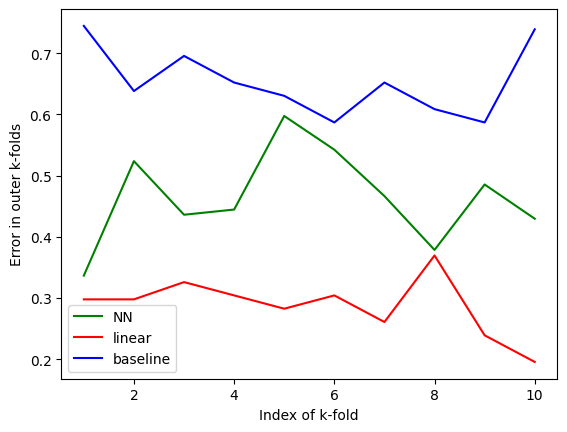

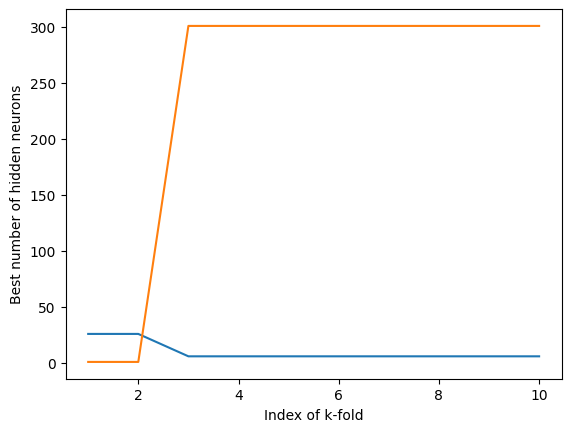

In [154]:
indices = np.arange(1, 11, 1)
plt.plot(indices, E_i_NN, 'g', label="NN")
plt.plot(indices, E_i_LogClass, 'r', label="linear")
plt.plot(indices, baseline_loss, 'b', label='baseline')
plt.legend()
plt.xlabel("Index of k-fold")
plt.ylabel("Error in outer k-folds")
plt.show()
plt.plot(indices, best_model_NN)
plt.plot(indices, best_model_LogClass)
plt.xlabel("Index of k-fold")
plt.ylabel("Best number of hidden neurons")
plt.show()

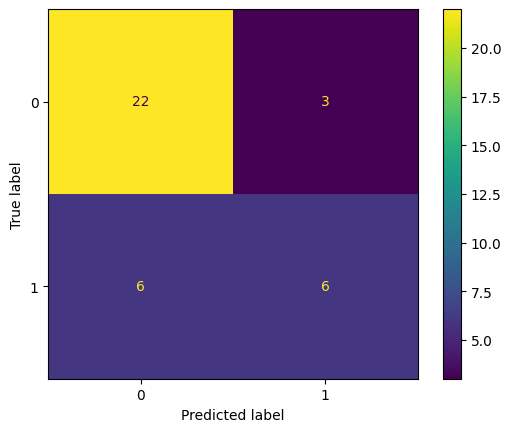

In [47]:
ConfusionMatrixDisplay(conf).plot()

In [156]:
# best_model_mean = [round(np.mean(x),) for x in np.split(best_model, 10)]
# test_error_mean = [round(np.mean(x),3) for x in np.split(test_errors, 10)]
# len(best_model_NN), len(E_i_NN), len(best_model_LogClass), len(E_i_LogClass) 

data = pd.DataFrame({"h*_i": best_model_NN, "E_i_NN": E_i_NN, "$\lambda$": best_model_LogClass, "E_i_Linear": E_i_LogClass, "Baseline": baseline_loss})
data

,h*_i,E_i_NN,$\lambda$,E_i_Linear,Baseline
0,26.0,0.336670,1.0,0.297872,0.744681
1,26.0,0.523719,1.0,0.297872,0.638298
2,6.0,0.436152,301.0,0.326087,0.695652
3,6.0,0.444627,301.0,0.304348,0.652174
4,6.0,0.597517,301.0,0.282609,0.630435
5,6.0,0.542473,301.0,0.304348,0.586957
6,6.0,0.466629,301.0,0.260870,0.652174
7,6.0,0.378644,301.0,0.369565,0.608696
8,6.0,0.485595,301.0,0.239130,0.586957
9,6.0,0.429663,301.0,0.195652,0.739130


In [170]:
dat = {"A": (E_i_NN-E_i_LogClass)/10, "B": (E_i_NN-best_model_LogClass)/10, "C": (best_model_LogClass-E_i_LogClass)/10}
dat['C']

array([ 0.07021277,  0.07021277, 30.0673913 , 30.06956522, 30.07173913,
       30.06956522, 30.07391304, 30.06304348, 30.07608696, 30.08043478])